In [1]:
import cv2
import os
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
os.chdir('DefectData')

In [2]:
testimages = list(sorted(glob('./test/[0-9][0-9][0-9][0-9][0-9].png')))
testimages.sort()
testmasks = list(sorted(glob('./test/[0-9][0-9][0-9][0-9][0-9]_GT.png')))
testmasks.sort()

In [37]:
predmasks = np.zeros(len(testimages), dtype = object)
for i, imagepath in enumerate(testimages):
    image = cv2.imread(imagepath)
    mask = cv2.imread(testmasks[i], 0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    thresh = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    __, thresh = cv2.threshold(thresh, 56, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    thresh = cv2.dilate(thresh, kernel, iterations = 5)
    predmasks[i] = thresh

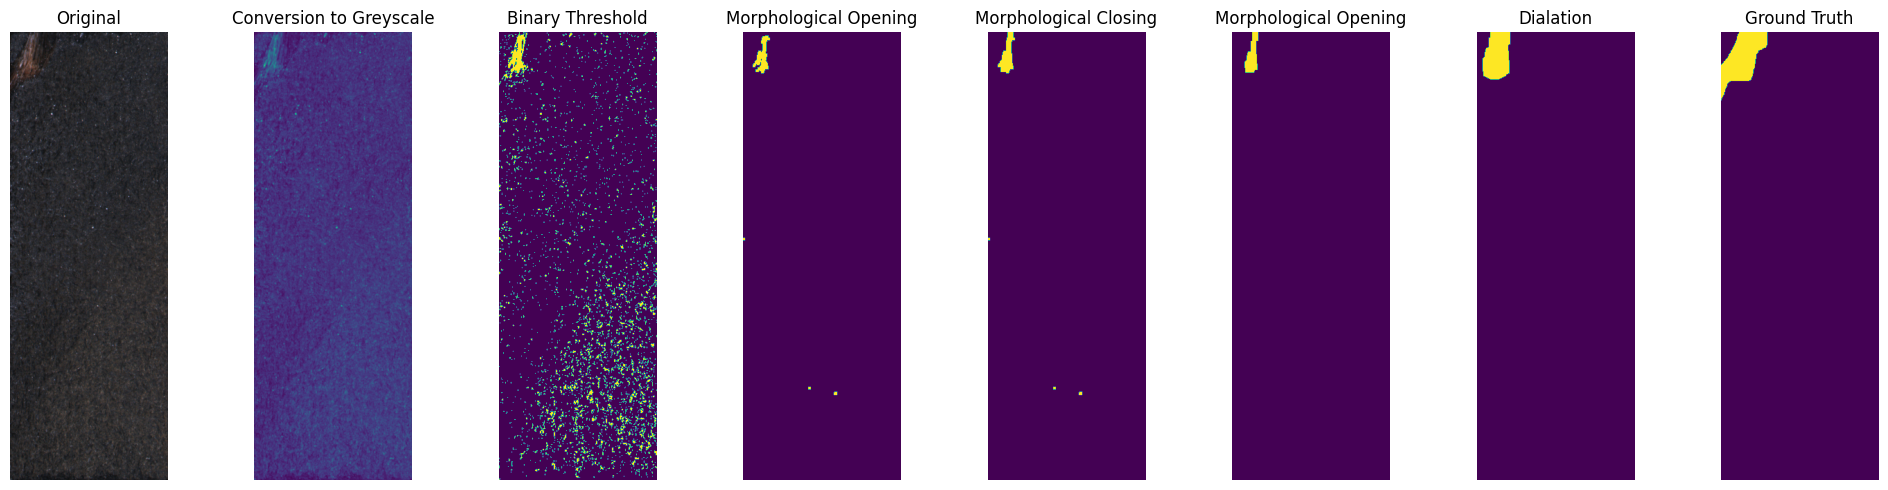

In [71]:
imagepath = 'train/10021.png'
maskpath = 'train/10021_GT.png'

image = cv2.imread(imagepath)
mask = cv2.imread(maskpath, 0)
predmask = np.zeros_like(mask)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

thresh1 = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
__, thresh2 = cv2.threshold(thresh1, 56, 158, cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
thresh3 = cv2.morphologyEx(thresh2, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
thresh4 = cv2.morphologyEx(thresh3, cv2.MORPH_CLOSE, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8))
thresh5 = cv2.morphologyEx(thresh4, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
thresh6 = cv2.dilate(thresh5, kernel, iterations = 5)

plt.figure(figsize = (20, 5))
plt.subplot(181)
plt.imshow(image)
plt.axis('off')
plt.title('Original')

plt.subplot(182)
plt.imshow(thresh1)
plt.axis('off')
plt.title('Conversion to Greyscale')

plt.subplot(183)
plt.imshow(thresh2)

plt.axis('off')
plt.title('Binary Threshold')

plt.subplot(184)
plt.imshow(thresh3)

plt.axis('off')
plt.title('Morphological Opening')

plt.subplot(185)
plt.imshow(thresh4)

plt.axis('off')
plt.title('Morphological Closing')

plt.subplot(186)
plt.imshow(thresh5)

plt.axis('off')
plt.title('Morphological Opening')

plt.subplot(187)
plt.imshow(thresh6)

plt.axis('off')
plt.title('Dialation')

plt.subplot(188)
plt.imshow(mask)

plt.axis('off')
plt.title('Ground Truth')

plt.tight_layout()


In [41]:
from tqdm import tqdm
testimages = list(sorted(glob('./test/[0-9][0-9][0-9][0-9][0-9].png')))
testimages.sort()
testmasks = list(sorted(glob('./test/[0-9][0-9][0-9][0-9][0-9]_GT.png')))
testmasks.sort()

ious = []

for i, fpath in enumerate(tqdm(testimages)):

    predmask = predmasks[i]
    predmask = np.clip(predmask, 0, 1)
    mask = cv2.imread(testmasks[i],0)
    mask = np.clip(mask, 0,1)

    intersection = np.sum(mask&predmask)
    union = np.sum(mask|predmask)
    if union>0:
        ious.append(float(intersection)/union)
    else:
        ious.append(1)

100%|██████████| 1004/1004 [00:00<00:00, 2396.28it/s]


In [42]:
print(np.average(ious))

0.7436929240135459


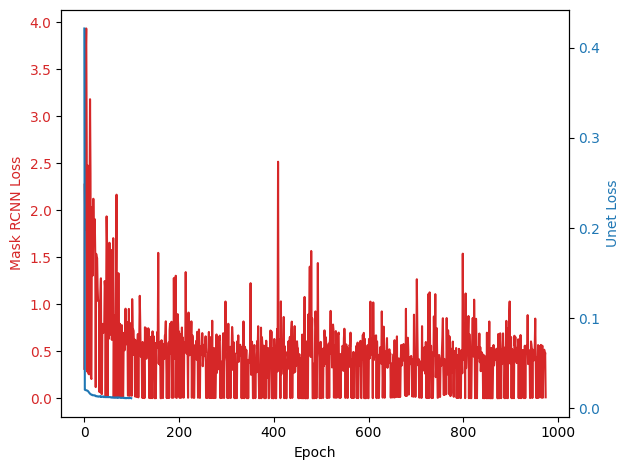

In [65]:
unetloss = np.load('unet_loss.npy')
maskrcnnloss = np.load('maskloss.npy')

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mask RCNN Loss', color=color)
ax1.plot(range(len(maskrcnnloss)), maskrcnnloss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Unet Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(unetloss)), unetloss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()